In [127]:
from math import pi
import matplotlib.pyplot as plt
from pennylane import numpy as np
import pennylane as qml
from pennylane.optimize import AdamOptimizer
import datetime
now=datetime.datetime.now

In [128]:
num_qubits=2
dev=qml.device('default.qubit', wires=num_qubits)
seed = 55
np.random.seed(seed)
print(seed)

55


In [129]:
# Boundary condition 
coefii = 1

# del_0 = 0  #del
# omega_0 = 0     #w
del_0_v = -1/coefii
omega_0_v = 383.9911/coefii

In [130]:
# Differential equation parameters
ws = 376.9911

# ws = 0.376
# coefii = ws/4
K1 = 5/coefii
K2 = 10/coefii
K3 = 1.7/coefii
ws = ws/coefii

def F_E1(delta_prime, delta,omega_prime,omega, t):       # DE, works with numpy arrays
    return (delta_prime+ws-omega)
    # return X_prime+ws-Y 

def F_E2(delta_prime, delta,omega_prime,omega, t):       # DE, works with numpy arrays
    # return Y_prime
    return omega_prime-K1+K2*coefii*delta+K3*(-ws+omega)*coefii

In [131]:
# # Differential equation's exact solution - for comparison
# def X_t(t):
#     # return X_0_v*np.cos(t)+(3*X_0_v+2*Y_0_v)*np.sin(t)
#     return 0

# def Y_t(t):
#     return 0

In [132]:
# t=np.random.uniform(0,1,size=50,requires_grad=False)
t = [0.0, 0.02040816326530612, 0.04081632653061224, 0.061224489795918366, 0.08163265306122448, 0.10204081632653061, 0.12244897959183673, 0.14285714285714285, 0.16326530612244897, 0.1836734693877551, 0.20408163265306123, 0.22448979591836735, 0.24489795918367346, 0.2653061224489796, 0.2857142857142857, 0.30612244897959184, 0.32653061224489793, 0.3469387755102041, 0.3673469387755102, 0.3877551020408163, 0.40816326530612246, 0.42857142857142855, 0.4489795918367347, 0.46938775510204084, 0.4897959183673469, 0.5102040816326531, 0.5306122448979592, 0.5510204081632653, 0.5714285714285714, 0.5918367346938775, 0.6122448979591837, 0.6326530612244898, 0.6530612244897959, 0.673469387755102, 0.6938775510204082, 0.7142857142857143, 0.7346938775510204, 0.7551020408163265, 0.7755102040816326, 0.7959183673469388, 0.8163265306122449, 0.8367346938775511, 0.8571428571428571, 0.8775510204081632, 0.8979591836734694, 0.9183673469387755, 0.9387755102040817, 0.9591836734693877, 0.9795918367346939, 1.0]


In [133]:
# define embedding layer
def embedding(x,wires):
    qml.RY(x, wires=wires[1])

In [134]:
def Ham():
    obs=[]
    for j in range(num_qubits):
        obs.append(qml.PauliX(j))
        for k in range(j):
            obs.append(qml.PauliZ(j)@qml.PauliZ(k))
    coeffs=np.random.uniform(-1,1,len(obs))*10
    qml.Hamiltonian(coeffs, obs)

In [135]:
# define ansastz layer
def layer(theta):
    
    # Apply Hamiltonian matrix
    Ham()
    
    # Apply H gate
    qml.Hadamard(0)
    
    # rotations on qubit 1
    qml.RY(theta,wires=1)
    
    # CNOT
    qml.CNOT(wires=[0, 1])

In [136]:
@qml.qnode(dev, diff_method="backprop", interface="autograd")
def quantum_net(theta,x):
    
    # encode data
    embedding(x,wires=range(num_qubits))
    
    # parameterized circuit layers
    for v in theta: # (for lool along with the first dimension)
        # print(v)
        # Ham()
        layer(v)
    
    qml.Hadamard(0)
    
    # return qml.expval(qml.PauliZ(0)),qml.expval(qml.PauliZ(1))
    return qml.expval(qml.PauliZ(0))

In [137]:
num_layers=4
theta1=np.random.uniform(0,2*pi,size=(num_layers,num_qubits-1),requires_grad=True)
# theta2=np.random.uniform(0,2*pi,size=(num_layers,num_qubits-1),requires_grad=True)
theta1 = np.load('theta20.npy')
print(qml.draw(quantum_net)(theta1,0))

0: ──H────────────────╭●──H──────╭●──H──────╭●──H──────╭●──H─┤  <Z>
1: ──RY(0.00)──RY(M0)─╰X──RY(M1)─╰X──RY(M2)─╰X──RY(M3)─╰X────┤     
M0 = 
[0.19281925]
M1 = 
[6.27760015]
M2 = 
[1.5686684]
M3 = 
[2.057436]


In [138]:
# add the classical layer   #TODO
def classical_quantum_net(theta,w,t):

    r1=quantum_net(theta,t)[0]
    # r2=quantum_net(theta,x)[1]
    # return w[0]+w[1]*r1+w[2]*r1**2+w[3]*r2+w[4]*r2**2
    return w[0]+w[1]*r1+w[2]*r1**2
    # r1=quantum_net(theta,x)
    return r1

In [139]:
# add the classical layer   #TODO
def classical_quantum_net_efficient(r1,w):
    return w[0]+w[1]*r1+w[2]*r1**2

In [140]:
def classical_quantum_net_prime(theta,w,t):



    r1=quantum_net(theta,t)[0]

    r1_prime = qml.grad(quantum_net,argnum=1)(theta,np.tensor(t)) 
    # r2=quantum_net(theta,x)[1]
    # return w[0]+w[1]*r1+w[2]*r1**2+w[3]*r2+w[4]*r2**2
    return w[1]*r1_prime+2*w[2]*r1_prime*r1


In [141]:
def classical_quantum_net_double_prime(theta,w,t):

   r1=quantum_net(theta,t)[0]
   r1_prime = qml.grad(quantum_net,argnum=1)(theta,np.tensor(t)) 


   #Calculate double prime
   F_pos_pos_pi = quantum_net(theta,t+np.pi)[0]
   F_phi = quantum_net(theta,t)[0]
   F_phi_neg_pi = quantum_net(theta,t-np.pi)[0]
   r1_double_prime = (1/4)*(F_pos_pos_pi-2*F_phi+F_phi_neg_pi)


   return w[1]*r1_double_prime+2*w[2]*(r1_prime*r1_prime+r1*r1_double_prime)

In [142]:
# def square_loss(labels,predictions):
#     loss=0
#     for l,p in zip(labels,predictions):
#         loss=loss+(l-p)**2
#     loss=loss/len(labels)
#     return loss

In [143]:
# #loss boundary
# def loss_b(U_predict):
    
    

In [144]:
def cost(theta1,w1,t):

    # loss inner points
    loss_i = 0

    del_t_pred = np.array([classical_quantum_net(theta=theta1,w=w1,t=point) for point in t])
    del_t_prime = np.array([classical_quantum_net_prime(theta=theta1,w=w1,t=point) for point in t])
    
    omega_t_pred = del_t_prime+ws
    # Y_t_prime = np.array([classical_quantum_net_prime(theta=theta2,w=w2,t=point) for point in t])
    omega_t_prime = np.array([classical_quantum_net_double_prime(theta=theta1,w=w1,t=point) for point in t])

    loss_i += np.mean(F_E1(delta=del_t_pred,omega=omega_t_pred,delta_prime=del_t_prime,omega_prime=omega_t_prime,t=t)**2)
    loss_i += np.mean(F_E2(delta=del_t_pred,omega=omega_t_pred,delta_prime=del_t_prime,omega_prime=omega_t_prime,t=t)**2)

    # # loss boundary points
    loss_b = 0
    del_0_pred = classical_quantum_net(theta1,w1,0)
    omega_0_pred = classical_quantum_net_prime(theta1,w1,0)+ws

    # # print(U_0)
    loss_b += (del_0_v-del_0_pred)**2+(omega_0_v-omega_0_pred)**2
    return 2*loss_b + loss_i
    # return 0.2*loss_b + 0.8*loss_i

    return loss_i

In [145]:
w1=np.zeros(3,requires_grad=True)
w1 = np.load('w20.npy')

# w2=np.zeros(3,requires_grad=True)
opt = AdamOptimizer(0.05, beta1=0.9, beta2=0.999)

In [146]:
start=now()
print(start)

2023-09-07 19:07:05.498336


In [147]:
epochs=100
cost_max = 10000
theta1_best = None
w1_best = None

# theta1=np.load('theta40.npy')
# w1= np.load('w40.npy')


for e in range(1,epochs+1):

    # (theta1,theta2,w1,w2,_),_cost=opt.step_and_cost(cost,theta1,theta2,w1,w2,t)
    (theta1,w1,_),_cost=opt.step_and_cost(cost,theta1,w1,t)

    if _cost<cost_max:
        cost_max = _cost
        theta1_best = theta1
        w1_best = w1

    # (theta,_),_cost=opt.step_and_cost(cost,theta,t)
    if e==1 or e%1==0:
        print(f'Epoch: {e} | Cost: {_cost}')



Epoch: 1 | Cost: 6.078365809293225
Epoch: 2 | Cost: 12.719585312007256
Epoch: 3 | Cost: 6.286768127237584
Epoch: 4 | Cost: 8.190653467363331
Epoch: 5 | Cost: 10.056031744484399
Epoch: 6 | Cost: 8.89584491403486
Epoch: 7 | Cost: 6.918814472748972
Epoch: 8 | Cost: 6.081715276332982
Epoch: 9 | Cost: 6.718447253309346
Epoch: 10 | Cost: 7.557400077956304
Epoch: 11 | Cost: 7.433794018765865
Epoch: 12 | Cost: 6.639950036726945
Epoch: 13 | Cost: 6.124305346212416
Epoch: 14 | Cost: 6.326181496521172
Epoch: 15 | Cost: 6.857995661607008
Epoch: 16 | Cost: 7.067675996018583
Epoch: 17 | Cost: 6.762187226998042
Epoch: 18 | Cost: 6.294708453703062
Epoch: 19 | Cost: 6.118693570399385
Epoch: 20 | Cost: 6.328470964824569
Epoch: 21 | Cost: 6.595655389923782
Epoch: 22 | Cost: 6.584514924400162
Epoch: 23 | Cost: 6.330140607956563
Epoch: 24 | Cost: 6.119664201517836
Epoch: 25 | Cost: 6.13182222468504
Epoch: 26 | Cost: 6.28273741397213
Epoch: 27 | Cost: 6.370958640596214
Epoch: 28 | Cost: 6.3001470800658605
E

In [148]:
seed =20
np.save('theta'+str(seed), theta1)
np.save('w'+str(seed),w1)
print(theta1)
print(w1)

[[0.22080988]
 [6.31827787]
 [1.60064338]
 [2.03463734]]
[ 1.02763522 -4.06351675 -5.89775763]


In [150]:
def delta(t):
    sqrt_10 = np.sqrt(10)
    result = (7 * np.sin(sqrt_10 * t) / sqrt_10) - (3 * np.cos(sqrt_10 * t) / 2) + 1/2
    return result

def omega(t):
    sqrt_10 = np.sqrt(10)
    result = (3*sqrt_10 * np.sin(sqrt_10 * t) / 2) + (7 * np.cos(sqrt_10 * t)) + (3769911/10000)
    return result
y_delta_real = [delta(t) for t in t]
y_omega_real = [omega(t) for t in t]
# print(y_delta_real)


In [151]:
# print(_cost)
# t=np.random.uniform(0,1,size=50,requires_grad=False)
print(t)
pred_train_X=np.array([classical_quantum_net(theta1,w1,t) for t in t])
pred_train_Y=(np.array([classical_quantum_net_prime(theta1,w1,t) for t in t])+ws)
print(pred_train_X)
print(pred_train_Y)
# pred_train_Y=np.array([classical_quantum_net(theta2,w2,t) for t in t])

[0.0, 0.02040816326530612, 0.04081632653061224, 0.061224489795918366, 0.08163265306122448, 0.10204081632653061, 0.12244897959183673, 0.14285714285714285, 0.16326530612244897, 0.1836734693877551, 0.20408163265306123, 0.22448979591836735, 0.24489795918367346, 0.2653061224489796, 0.2857142857142857, 0.30612244897959184, 0.32653061224489793, 0.3469387755102041, 0.3673469387755102, 0.3877551020408163, 0.40816326530612246, 0.42857142857142855, 0.4489795918367347, 0.46938775510204084, 0.4897959183673469, 0.5102040816326531, 0.5306122448979592, 0.5510204081632653, 0.5714285714285714, 0.5918367346938775, 0.6122448979591837, 0.6326530612244898, 0.6530612244897959, 0.673469387755102, 0.6938775510204082, 0.7142857142857143, 0.7346938775510204, 0.7551020408163265, 0.7755102040816326, 0.7959183673469388, 0.8163265306122449, 0.8367346938775511, 0.8571428571428571, 0.8775510204081632, 0.8979591836734694, 0.9183673469387755, 0.9387755102040817, 0.9591836734693877, 0.9795918367346939, 1.0]
[-0.29833513 

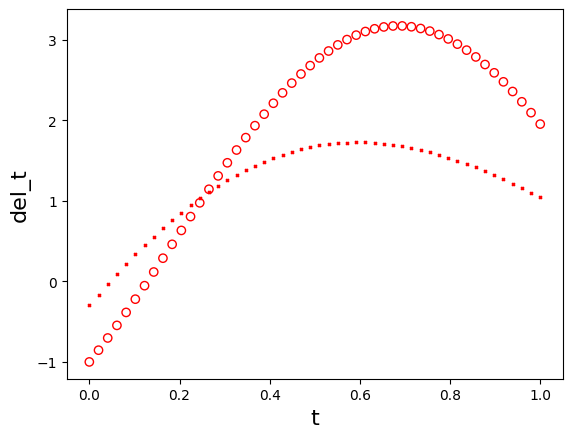

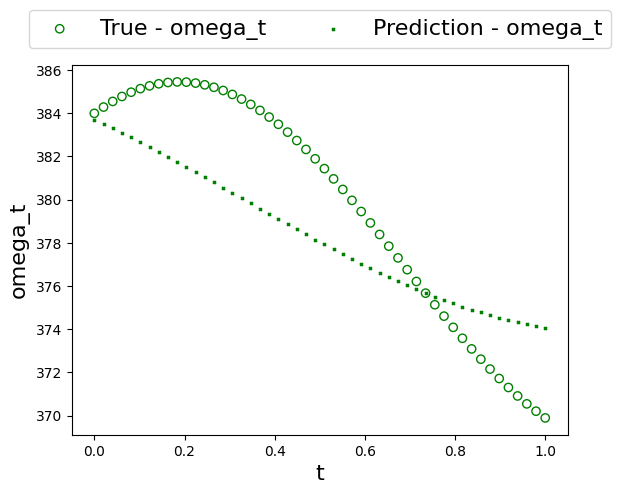

In [152]:
plt.figure()

plt.scatter(t,y_delta_real,facecolors='none', edgecolors='r', label='True - del_t')
plt.scatter(t,pred_train_X, color='red',marker="x",s=4,label='Prediction - del_t')
plt.xlabel('t',fontsize=16)
plt.ylabel('del_t',fontsize=16)
plt.figure()
plt.scatter(t,y_omega_real,facecolors='none', edgecolors='g', label='True - omega_t')

plt.scatter(t,pred_train_Y, color='green',marker="x",s=4,label='Prediction - omega_t')

plt.xlabel('t',fontsize=16)
plt.ylabel('omega_t',fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(loc='upper center',bbox_to_anchor=(0.5,1.18),ncol=2,fontsize=16)
# plt.savefig('1_measurement2_train.png')
plt.show()